In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import sys
from pdb import set_trace

from dataclasses import asdict

from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.normalize import Normalize, Unnormalize
from lerobot.common.datasets.utils import cycle

from lerobot.common.policies.act.configuration_act import ACTConfig
from lerobot.common.policies.act.modeling_act import ACTPolicy

import torch
import multiprocessing as mp

from aim import Run

# Set hyperparams and enable experiment tracking

In [3]:
config = ACTConfig(n_action_steps=20)
dry_run = False

if dry_run:
    training_steps = 10
    eval_frequency = 5
else:
    training_steps = 5000 * 5  # 5 was the dataloader length in ACT, one step was equivalent to training with 
                               # 40 examples with a batch size of 8
    eval_frequency = 500 * 5
    
run = Run(experiment="transfer_cube_lerobot", repo='dry_run' if dry_run else None)
run["hparams"] = asdict(config)

# Create dataloaders

In [4]:
delta_timestamps = {
    "action": [t / 50 for t in range(config.chunk_size)],  # this dataset was recorded at 50Hz
}
train_dataset = LeRobotDataset('lerobot/aloha_sim_transfer_cube_scripted', split='train[:80%]', delta_timestamps=delta_timestamps)
val_dataset = LeRobotDataset('lerobot/aloha_sim_transfer_cube_scripted', split='train[80%:]', delta_timestamps=delta_timestamps)

Fetching 56 files:   0%|          | 0/56 [00:00<?, ?it/s]

Fetching 56 files:   0%|          | 0/56 [00:00<?, ?it/s]

# Create DataLoaders

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=mp.cpu_count()-1,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

In [6]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    num_workers=mp.cpu_count()-1,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

# Train

In [7]:
# use imagenet stats for normalization of images
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]
train_dataset.stats['observation.images.top']['mean'] = torch.tensor(imagenet_mean)[:, None, None]
train_dataset.stats['observation.images.top']['std'] = torch.tensor(imagenet_std)[:, None, None]

policy = ACTPolicy(config=config, dataset_stats=train_dataset.stats)

In [8]:
n_parameters = sum(p.numel() for p in policy.parameters() if p.requires_grad)
print("number of parameters: %.2fM" % (n_parameters/1e6))

number of parameters: 51.61M


In [9]:
policy.cuda();

optimizer = torch.optim.Adam(policy.parameters(), lr=1e-5)

In [10]:
%%time

train_iter = cycle(train_dataloader)

def move_batch_to_GPU(batch):
    return {k: v.cuda(non_blocking=True) for k, v in batch.items()}

for step in range(training_steps):
    policy.train()
    batch = next(train_iter)
    batch = move_batch_to_GPU(batch)
    output_dict = policy.forward(batch)
    loss = output_dict["loss"]
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(f"Step: {step}\tTrain loss: {loss}", end="\r")
    run.track(loss, name='loss', step=step, context={"subset": "train"})

    if (step % eval_frequency == 0 and step != 0) or step == training_steps-1:
        policy.eval()
        loss_cumsum = 0
        n_examples_evaluated = 0
        with torch.inference_mode():
            for batch in val_dataloader:
                batch = move_batch_to_GPU(batch)
                output_dict = policy.forward(batch)
                
                loss_cumsum += output_dict["loss"].item()
                n_examples_evaluated += batch['index'].shape[0]

        validation_loss = loss_cumsum / n_examples_evaluated
        
        print(f"Step: {step}\tVal loss: {loss}")
        run.track(validation_loss, name='loss', step=step, context={"subset": "val"})

        policy.save_pretrained(f'models/ACT_{step}')

Step: 2500	Val loss: 1.014393329620361313
Step: 5000	Val loss: 0.4613967835903168685
Step: 7500	Val loss: 0.1330701410770416363
Step: 10000	Val loss: 0.082920119166374242
Step: 12500	Val loss: 0.07505200803279877775
Step: 15000	Val loss: 0.05818342044949531616
Step: 17500	Val loss: 0.05514597892761230505
Step: 20000	Val loss: 0.04413726180791855554
Step: 22500	Val loss: 0.03960797935724258484
Step: 24999	Val loss: 0.03989895805716514646
CPU times: user 36min 36s, sys: 5min 4s, total: 41min 41s
Wall time: 35min 55s


# Run rollout validation at end of training (simulation)

In [11]:
import gymnasium as gym
import gym_aloha

env = gym.make(
    "gym_aloha/AlohaTransferCube-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=500
)
numpy_observation, info = env.reset()
frames = []
frames.append(env.render())

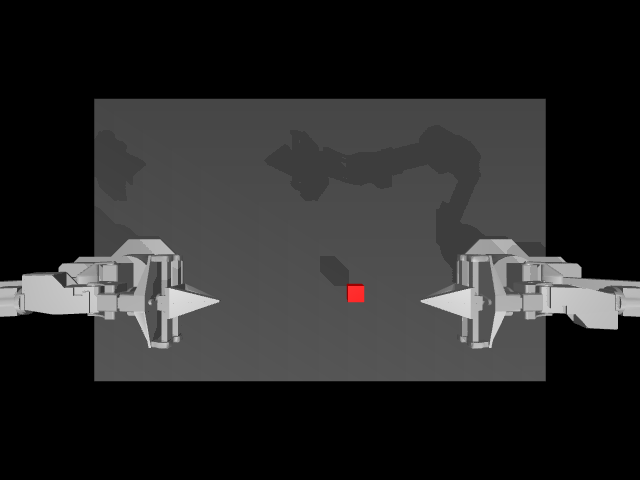

In [12]:
# starting positions of our simulated arms

import imageio
from IPython.display import Image

Image(imageio.imwrite('<bytes>', frames[0], format='PNG'))

In [13]:
# https://github.com/huggingface/lerobot/blob/main/examples/2_evaluate_pretrained_policy.py

step = 0
done = False
rewards, frames = [], []
while not done:
    state = torch.from_numpy(numpy_observation["agent_pos"])
    image = torch.from_numpy(numpy_observation["pixels"]['top'])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)

    # Send data tensors from CPU to GPU
    state = state.to('cuda', non_blocking=True)
    image = image.to('cuda', non_blocking=True)

    # Add extra (empty) batch dimension, required to forward the policy
    state = state.unsqueeze(0)
    image = image.unsqueeze(0)

    # Create the policy input dictionary
    observation = {
        "observation.state": state,
        "observation.images.top": image,
    }

    # Predict the next action with respect to the current observation
    with torch.inference_mode():
        action = policy.select_action(observation)
    
    # Prepare the action for the environment
    numpy_action = action.squeeze(0).to("cpu").numpy()

    # Step through the environment and receive a new observation
    numpy_observation, reward, terminated, truncated, info = env.step(numpy_action)
    print(f"{step=} {reward=} {terminated=}")

    # Keep track of all the rewards and frames
    rewards.append(reward)
    frames.append(env.render())

    # The rollout is considered done when the success state is reach (i.e. terminated is True),
    # or the maximum number of iterations is reached (i.e. truncated is True)
    done = terminated | truncated | done
    step += 1

if terminated:
    print("Success!")
else:
    print("Failure!")

# Get the speed of environment (i.e. its number of frames per second).
fps = env.metadata["render_fps"]

# Encode all frames into a mp4 video.
video_file_name = "rollout_LeRobot_only.mp4"
imageio.mimsave(video_file_name, frames, fps=fps)

print(f"Video of the evaluation is available in '{video_file_name}'.")

step=0 reward=0 terminated=False
step=1 reward=0 terminated=False
step=2 reward=0 terminated=False
step=3 reward=0 terminated=False
step=4 reward=0 terminated=False
step=5 reward=0 terminated=False
step=6 reward=0 terminated=False
step=7 reward=0 terminated=False
step=8 reward=0 terminated=False
step=9 reward=0 terminated=False
step=10 reward=0 terminated=False
step=11 reward=0 terminated=False
step=12 reward=0 terminated=False
step=13 reward=0 terminated=False
step=14 reward=0 terminated=False
step=15 reward=0 terminated=False
step=16 reward=0 terminated=False
step=17 reward=0 terminated=False
step=18 reward=0 terminated=False
step=19 reward=0 terminated=False
step=20 reward=0 terminated=False
step=21 reward=0 terminated=False
step=22 reward=0 terminated=False
step=23 reward=0 terminated=False
step=24 reward=0 terminated=False
step=25 reward=0 terminated=False
step=26 reward=0 terminated=False
step=27 reward=0 terminated=False
step=28 reward=0 terminated=False
step=29 reward=0 termina

In [14]:
from IPython.display import Video

video = Video(video_file_name, width=320, height=240)
video

With training, validation loss -- just like with any other type of DL model -- becomes an imprecise descriptor of the quality of learned model. Possibly in robotics to an even greater degree than in CV or NLP.

This notebook is for demonstration purposes only, but to monitor training it might be worthwile to run rollout validation regularly doing trianing and to do multiple rollouts per single validation run (rollouts begin with randomized position of the cube and measuring success rate such as x successes from 100 rollouts is a very useful piece of information).

In [15]:
run.track(terminated, name='success')
run.close()